In [8]:
from BinaryCrossEntropyLoss import BinaryCrossEntropyLoss
from matplotlib import pyplot as plt
from OptTensor import OptTensor
import numpy as np

### Dataset Class

In [20]:
from torch.utils.data import Dataset, random_split, DataLoader
from torch import Generator
class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __getitem__(self, index):
        sample = {
            "features": self.x[index],
            "label": self.y[index]
        }
        return sample
    def __len__(self):
        return len(self.x)

### Picking sample to train on with same seed used the Pytorch Model

In [21]:
encoding_name = 'word2vec'
encoding = np.load(f'./data/{encoding_name}.npy')
labels = np.load('./data/label.npy')
seed = 42
generator =np.random.default_rng(seed=seed)
choices = generator.choice(np.arange(0, encoding.shape[0]), size=5000, replace=False)

### Creating Dataset with reduced Training set

In [22]:
mydata = MyDataset(encoding[choices], labels[choices])
t_generator = Generator().manual_seed(seed)
train_split, validation_split, test_split= random_split(mydata, [0.8, 0.1 , 0.1], generator=t_generator)
train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_split, batch_size=32)
test_loader = DataLoader(test_split, batch_size=32)

### Initializing Neural Network

In [42]:
linear1 = OptTensor(np.random.randn(100, 5000).astype(np.float64), name='Linear1')
linear2 = OptTensor(np.random.randn(5000, 300).astype(np.float64), name='Linear2')
linear3 = OptTensor(np.random.randn(300, 2).astype(np.float64), name='Linear3')
loss = BinaryCrossEntropyLoss()
learning_rate = 0.001
ave_losses = 0
ave_vlosses = 0
losses = []
vlosses = []
count = 0
vcount = 0
EPOCH = 10

In [43]:
for i in range(EPOCH):
  print("EPOCH ", i)
  for data in train_loader:
    x = data['features'].numpy()
    y = data['label'].numpy()
    lr1 = linear1(x).relu()
    lr2 = linear2(lr1).relu()
    lr3 = linear3(lr2)
    probs = lr3.softmax(temperature=100)
    current_loss = loss(probs, y)
    current_loss.backward()
    linear1.data -= learning_rate*linear1.grad
    linear2.data -= learning_rate*linear2.grad
    linear3.data -= learning_rate*linear3.grad
    ave_losses += current_loss.data
    count += 1

  for vdata in validation_loader:
    xv = vdata['features'].numpy()
    yv = vdata['label'].numpy()
    vlr1 = linear1(xv).relu()
    vlr2 = linear2(vlr1).relu()
    vlr3 = linear3(vlr2)
    vprobs = vlr3.softmax(temperature=100)
    vcurrent_loss = loss(vprobs, yv)
    ave_vlosses += vcurrent_loss.data
    vcount += 1
  losses.append(ave_losses / count)
  vlosses.append(ave_vlosses / vcount)

correct_guess = 0
samples = 0
for test_data in test_loader:
  x = test_data['features'].numpy()
  y = test_data['label'].numpy()
  lr1 = linear1(x)
  relu1 = lr1.relu()
  lr2 = linear2(lr1)
  relu2 = lr2.relu()
  lr3 = linear3(lr2)
  probs = lr3.softmax(temperature=1000)
  preds = probs.data.argmax(axis=1)
  correct_guess += (preds == y).sum()
  samples += x.shape[0]

EPOCH  0
EPOCH  1
EPOCH  2
EPOCH  3
EPOCH  4
EPOCH  5
EPOCH  6
EPOCH  7
EPOCH  8
EPOCH  9
FS Accuracy: 38.2


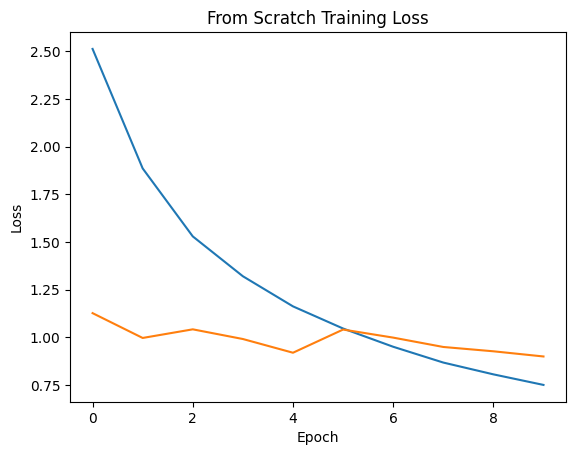

In [44]:
plt.plot(losses, label="Training Loss")
plt.plot(vlosses, label="Validation Loss")
plt.title("From Scratch Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('TrainingLoss.png')

### Comparing with PyTorch model

In [45]:
from collections import OrderedDict
import torch as t

class MyModel(t.nn.Module):
    def __init__(self):
        IN_DIM = 100
        super().__init__()
        self.model = t.nn.Sequential(OrderedDict([
            ("Linear1", t.nn.Linear(IN_DIM, 5000, dtype=t.float32)),
            ("Relu1", t.nn.ReLU()),
            ("Linear2", t.nn.Linear(5000, 300, dtype=t.float32)),
            ("Relu2", t.nn.ReLU()),
            ("Linear3", t.nn.Linear(300, 2, dtype=t.float32)),
        ]))
    def forward(self, x):
        return self.model(x)

model = t.load(f'./models/{encoding_name}.pt') 

In [46]:
def from_scratch_forward(x):
  lr1 = linear1(x).relu()
  lr2 = linear2(lr1).relu()
  lr3 = linear3(lr2)
  probs = lr3.softmax(temperature=100)
  return probs.data.argmax(axis=1)

def pytorch_forward(x):
  model.eval()
  return model(x).detach().numpy().argmax(axis=1)

In [47]:
seeds = range(42, 50)
pt_accuracies = []
fs_accuracies = []
for s in seeds:
  generator = np.random.default_rng(seed=s)
  choices = generator.choice(np.arange(0, encoding.shape[0]), size=5000, replace=False)
  mydata = MyDataset(encoding[choices], labels[choices])
  evaluation_loader = DataLoader(mydata, batch_size=32)
  fs_correct_guess = 0
  pt_correct_guess = 0
  count = 0
  for data in evaluation_loader:
    x, y = data["features"].numpy(), data["label"].numpy()
    fs_preds = from_scratch_forward(x)
    pt_preds = pytorch_forward(t.Tensor(x))
    fs_correct_guess += (fs_preds == y).sum()
    pt_correct_guess += (pt_preds == y).sum()
    count += x.shape[0]
  pt_accuracy = (pt_correct_guess / count)
  fs_accuracy = (fs_correct_guess / count)
  pt_accuracies.append(pt_accuracy)
  fs_accuracies.append(fs_accuracy)

In [51]:
from scipy.stats import ttest_ind
t_statistic, p_value = ttest_ind(pt_accuracies, fs_accuracies)
print(f'T-Statistic: {t_statistic}')
print(f'P-Value: {p_value}')

T-Statistic: 1.9725750217567688
P-Value: 0.06862753191457173


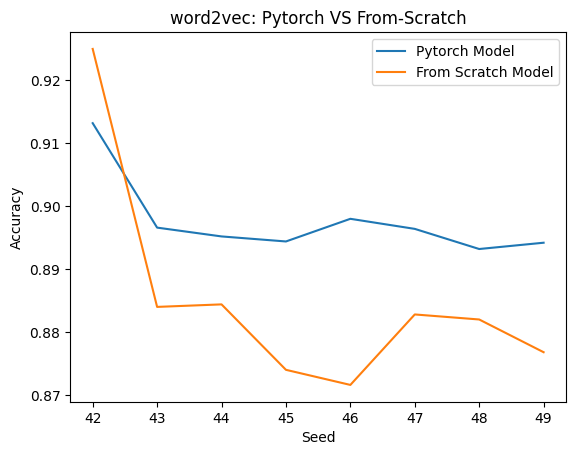

In [54]:
plt.plot(seeds, pt_accuracies, label="Pytorch Model")
plt.plot(seeds, fs_accuracies,label="From Scratch Model")
plt.title(f"{encoding_name}: Pytorch VS From-Scratch")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Seed")
plt.savefig(f'./{encoding_name}_pt_vs_fs.png')